# Predicting Newsletter Subscription Based on Session Behavior in Video Game Players

## *DSCI 100 - Final Project Report*

**Author:** Delia Zhang, Ryan Xie, Rachel McDonald, Oj Singh Dhillon   
**Date:** Fri, Apr 4th 

In [59]:
# Run this cell before continuing
library(tidyverse)

## Introduction

In the world of digital gaming, understanding what drives player engagement is essential for both game development and targeted communication strategies. One specific area of interest is the relationship between player behavior and subscription to game-related newsletters. Newsletters often serve as a marketing tool, allowing companies to inform players about new features, events, and updates. Understanding who is more likely to subscribe to these newsletters could help tailor marketing efforts and foster stronger community engagement.

### Research Question

**Can session length and frequency predict whether a player subscribes to the newsletter?**

We investigate this question using a dataset from a video game research server, containing player demographics and session activity logs. Specifically, we test the hypothesis that players who engage more frequently and for longer durations are more likely to subscribe to the game's newsletter.

In [60]:
# Load datasets
players <- read.csv("https://raw.githubusercontent.com/ryanraen/dsci-100-term-project/refs/heads/main/data/players.csv")
sessions <- read.csv("https://raw.githubusercontent.com/ryanraen/dsci-100-term-project/refs/heads/main/data/sessions.csv")

# View first 6 rows of datasets
head(players)
head(sessions)

,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


,hashedEmail,start_time,end_time,original_start_time,original_end_time
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
2,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
3,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
4,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
5,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
6,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


### Dataset Description

The data is composed of two primary CSV files:
- **players.csv**: Contains demographic and game engagement data for 196 individuals. Variables include:
  - `experience`: Player's self-rated experience level (e.g., Pro, Veteran, Amateur)
  - `subscribe`: Boolean indicator of newsletter subscription
  - `hashedEmail`: An anonymized player identifier
  - `played_hours`: Total hours the player has spent in-game
  - `name`: Player’s given name
  - `gender`: Gender identity
  - `Age`: Age in years

- **sessions.csv**: Contains 1,535 individual game session logs, with the following variables:
  - `hashedEmail`: The same anonymized player identifier as in `players.csv`
  - `start_time`, `end_time`: Session timestamps (character format)
  - `original_start_time`, `original_end_time`: Session timestamps in UNIX format

In [61]:
# Get data types for each dataset in a table format
players_types <- data.frame(
  variable = colnames(players),
  data_type = map_chr(players, class))

sessions_types <- data.frame(
  variable = colnames(sessions),
  data_type = map_chr(sessions, class))

players_types
sessions_types

,variable,data_type
,<chr>,<chr>
experience,experience,character
subscribe,subscribe,logical
hashedEmail,hashedEmail,character
played_hours,played_hours,numeric
name,name,character
gender,gender,character
Age,Age,integer


,variable,data_type
,<chr>,<chr>
hashedEmail,hashedEmail,character
start_time,start_time,character
end_time,end_time,character
original_start_time,original_start_time,numeric
original_end_time,original_end_time,numeric


In [62]:
# Creating a variable description table
players_variables <- data.frame(
  Variable = colnames(players),
  Description = c(
    "How experienced a player is",
    "Newsletter subscription status",
    "Hashed email address",
    "Total playtime (in hours)",
    "Player name",
    "Player gender",
    "Player age"))

sessions_variables <- data.frame(
  Variable = colnames(sessions),
  Description = c(
    "Hashed email address",
    "Session start time",
    "Session end time",
    "Session start time from UNIX",
    "Session end time from UNIX"))

players_variables
sessions_variables

Variable,Description
<chr>,<chr>
experience,How experienced a player is
subscribe,Newsletter subscription status
hashedEmail,Hashed email address
played_hours,Total playtime (in hours)
name,Player name
gender,Player gender
Age,Player age


Variable,Description
<chr>,<chr>
hashedEmail,Hashed email address
start_time,Session start time
end_time,Session end time
original_start_time,Session start time from UNIX
original_end_time,Session end time from UNIX


### Summary Statistics and Observations

The `players` dataset consists of 196 entries and 7 variables. The youngest player is 8 years old, while the oldest is 50. The median age is 19, with a standard deviation of approximately 6.17 years. The dataset shows a wide range in game engagement: some players have 0 recorded playtime while the maximum is over 220 hours. The standard deviation for playtime is 28.36 hours, indicating substantial variability.

The `sessions` dataset has 1,535 observations and 5 variables. Using the UNIX timestamps, we calculated summary statistics for session start and end times. The timestamps range over several months, and the standard deviation of start and end times is about 3.5 billion in UNIX units, suggesting a broad distribution of activity across time.

In [63]:
# Number of observations and variables  
dataset_summary <- data.frame(
  dataset = c("Players", "Sessions"),
  observations = c(nrow(players), nrow(sessions)),
  variables = c(ncol(players), ncol(sessions)))

dataset_summary

dataset,observations,variables
<chr>,<int>,<int>
Players,196,7
Sessions,1535,5


In [64]:
# Players summary
players_numeric_cols <- players |>
  select(Age, played_hours)

players_summary <- players_numeric_cols |>
  summarise(
    across(everything(), list(
      min = \(x) min(x, na.rm = TRUE),
      median = \(x) median(x, na.rm = TRUE),
      max = \(x) max(x, na.rm = TRUE),
      sd = \(x) sd(x, na.rm = TRUE)
    ))
  )

# Sessions summary
sessions_numeric_cols <- sessions |>
  select(original_start_time, original_end_time)

sessions_summary <- sessions_numeric_cols |>
  summarise(
    across(everything(), list(
      min = \(x) min(x, na.rm = TRUE),
      median = \(x) median(x, na.rm = TRUE),
      max = \(x) max(x, na.rm = TRUE),
      sd = \(x) sd(x, na.rm = TRUE)
    ))
  )

players_summary
sessions_summary

Age_min,Age_median,Age_max,Age_sd,played_hours_min,played_hours_median,played_hours_max,played_hours_sd
<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8,19,50,6.174667,0,0.1,223.1,28.35734


original_start_time_min,original_start_time_median,original_start_time_max,original_start_time_sd,original_end_time_min,original_end_time_median,original_end_time_max,original_end_time_sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.7124e+12,1.7192e+12,1.72733e+12,3557491589,1.7124e+12,1.71918e+12,1.72734e+12,3552813134


### Data Issues and Considerations

Before modeling, several data quality issues were considered:
- **Missing values**: Both datasets contained a small number of NA values (2 each), which were removed.
- **Outliers**: Some players had extremely long or short playtimes or session lengths.
- **Encoding**: Categorical variables (e.g., experience, gender) were not used in this model but could be considered in future work.
- **Duplicates**: No duplicate rows were found.
- **Session timestamps**: Required conversion to extract session durations in minutes.
- **Class imbalance**: The majority of players *are* subscribed to a newsletter.

By combining both datasets using the `hashedEmail` identifier, we calculated two key behavioral features for each player:
- **Average session length**: Mean time spent per session
- **Total session count**: Number of distinct sessions played

These variables form the basis of our predictive analysis.

In [65]:
# Checking for missing values
missing_values <- data.frame(
  dataset = c("Players", "Sessions"),
  total_missing_values = c(sum(is.na(players)), sum(is.na(sessions))))

# Checking for duplicate rows
duplicate_rows <- data.frame(
  dataset = c("Players", "Sessions"),
  total_duplicates = c(sum(duplicated(players)), sum(duplicated(sessions))))

missing_values
duplicate_rows

dataset,total_missing_values
<chr>,<int>
Players,2
Sessions,2


dataset,total_duplicates
<chr>,<int>
Players,0
Sessions,0


In [66]:
# Drop missing values
players_clean <- players |> drop_na()
sessions_clean <- sessions |> drop_na()

In [67]:
# Create session duration variable and aggregate
sessions_clean$duration <- as.numeric(as.POSIXct(sessions_clean$end_time, format="%d/%m/%Y %H:%M") -
                                      as.POSIXct(sessions_clean$start_time, format="%d/%m/%Y %H:%M"))

session_summary <- sessions_clean |> 
  group_by(hashedEmail) |>
  summarise(avg_session_length = mean(duration, na.rm = TRUE), num_sessions = n())

head(session_summary)

hashedEmail,avg_session_length,num_sessions
<chr>,<dbl>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,53.00000,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,30.00000,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,11.00000,1
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,32.15385,13
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,35.00000,2
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,10.00000,1


In [68]:
# Merge session data with player data
merged_data <- inner_join(players_clean, session_summary, by = "hashedEmail")

# Remove any remaining missing values
merged_data <- drop_na(merged_data)

head(merged_data)

,experience,subscribe,hashedEmail,played_hours,name,gender,Age,avg_session_length,num_sessions
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>,<dbl>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,74.77778,27
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,85.00000,3
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5.00000,1
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,50.00000,1
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,9.00000,1
6,Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,5.00000,1


 avg_session_length  num_sessions     played_hours          Age       
 Min.   :  5.00     Min.   :  1.00   Min.   :  0.000   Min.   : 8.00  
 1st Qu.: 10.00     1st Qu.:  1.00   1st Qu.:  0.100   1st Qu.:17.00  
 Median : 19.00     Median :  1.00   Median :  0.400   Median :19.00  
 Mean   : 32.85     Mean   : 12.45   Mean   :  9.313   Mean   :20.61  
 3rd Qu.: 46.00     3rd Qu.:  2.00   3rd Qu.:  1.500   3rd Qu.:22.50  
 Max.   :150.34     Max.   :310.00   Max.   :223.100   Max.   :50.00  

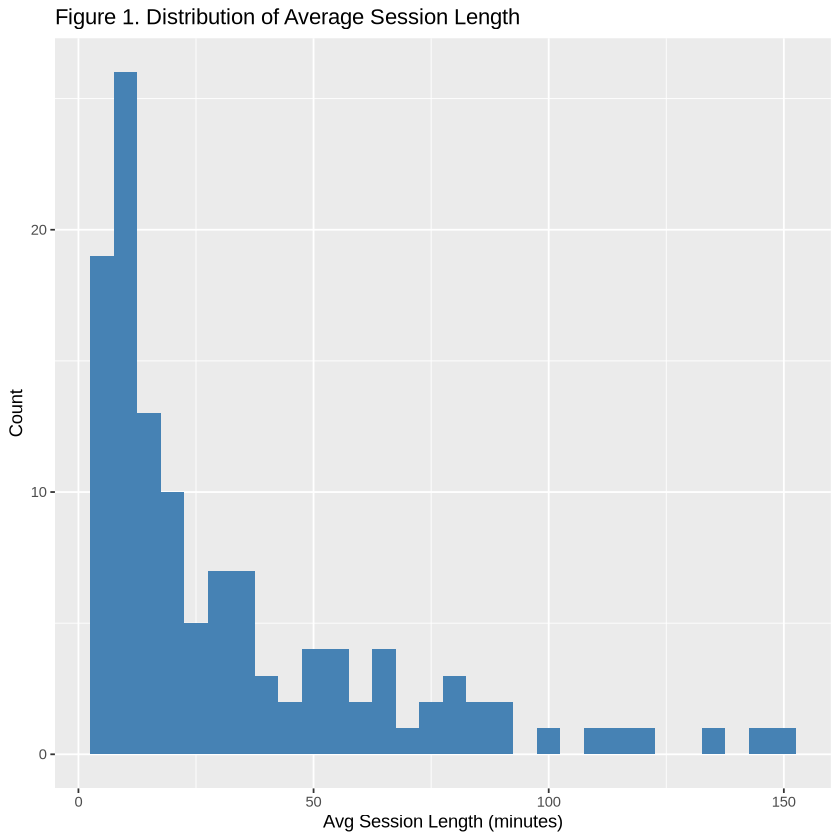

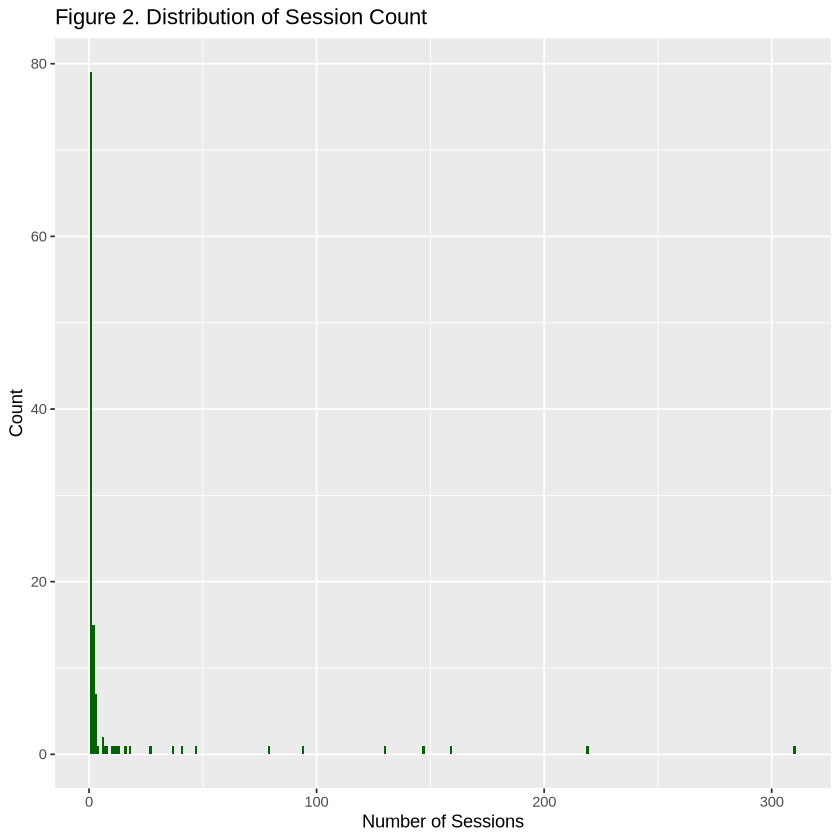

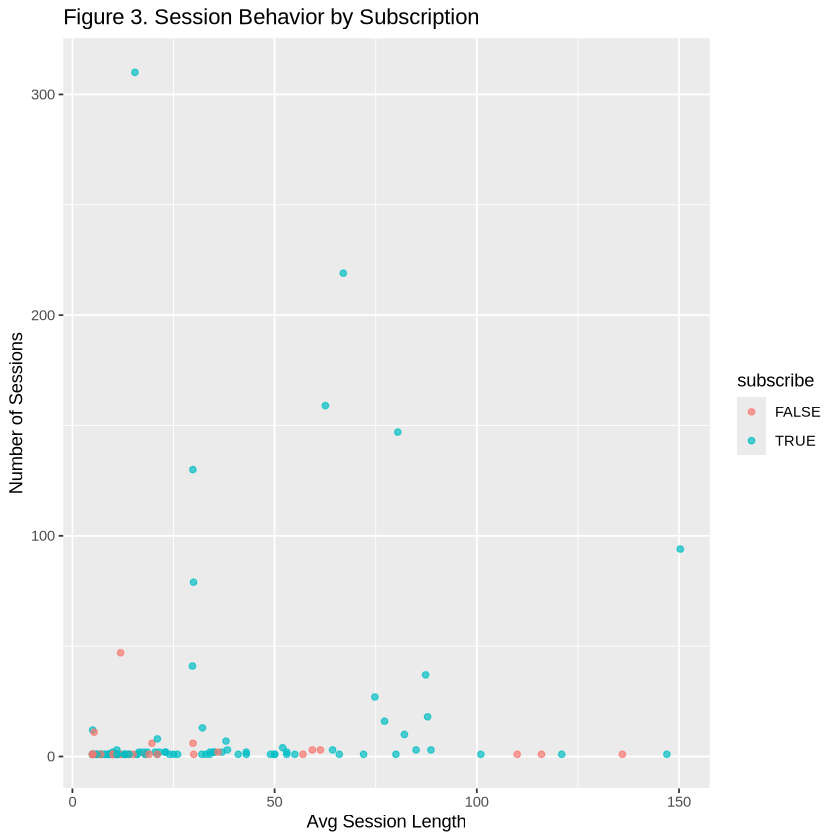

In [69]:
# Summary statistics
summary(merged_data[c("avg_session_length", "num_sessions", "played_hours", "Age")])

# Histogram of average session length
ggplot(merged_data, aes(x = avg_session_length)) +
  geom_histogram(binwidth = 5, fill = "steelblue") +
  labs(title = "Figure 1. Distribution of Average Session Length", x = "Avg Session Length (minutes)", y = "Count")

# Histogram of number of sessions
ggplot(merged_data, aes(x = num_sessions)) +
  geom_histogram(binwidth = 1, fill = "darkgreen") +
  labs(title = "Figure 2. Distribution of Session Count", x = "Number of Sessions", y = "Count")

# Scatterplot: avg session length vs. num sessions by subscription
ggplot(merged_data, aes(x = avg_session_length, y = num_sessions, color = subscribe)) +
  geom_point(alpha = 0.7) +
  labs(title = "Figure 3. Session Behavior by Subscription", x = "Avg Session Length", y = "Number of Sessions")

In [70]:
# Merge datasets and convert outcome to factor
merged_data <- players_clean |>
  inner_join(session_summary, by = "hashedEmail") |>
  drop_na() |>
  mutate(subscribe = as.factor(subscribe))

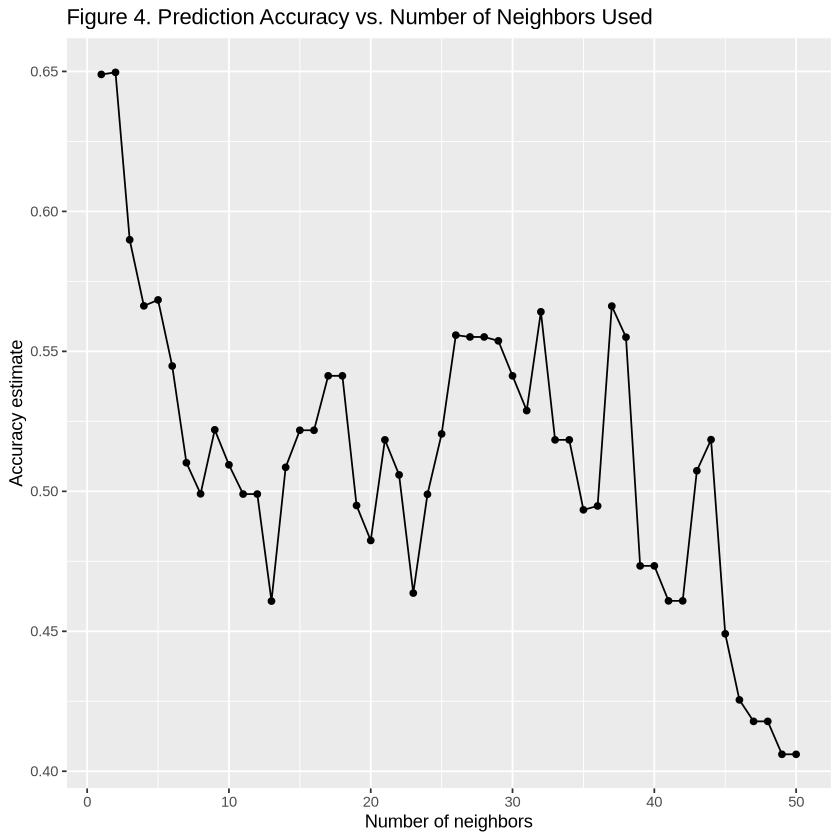

In [71]:
library(repr)
library(tidyverse)
library(tidymodels)
library(themis)
options(repr.matrix.max.rows = 10)

# Create recipe
knn_recipe <- recipe(subscribe ~ avg_session_length + num_sessions, data = merged_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  step_upsample(subscribe, over_ratio = 1, skip = TRUE)

# Create training/testing split
set.seed(123)
split <- initial_split(merged_data, prop = 0.7, strata = subscribe)
train_data <- training(split)
test_data <- testing(split)

# Define K-NN model
knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Workflow
knn_workflow <- workflow() |>
  add_model(knn_model) |>
  add_recipe(knn_recipe)

# Test K values 1-50
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

# Apply 5 vfold cross validation
data_vfold <- vfold_cv(train_data, v = 5, strata = subscribe)

k_metrics <- knn_workflow |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Isolate accuracies for each K value
accuracies <- k_metrics |>
  filter(.metric == "accuracy")

# Visualize prediction accuracy and number of neighbors
best_k_vis <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Figure 4. Prediction Accuracy vs. Number of Neighbors Used", x = "Number of neighbors", y = "Accuracy estimate")

best_k_vis

From the plot above, we can see that for:
- Small K values (1-10), there is a sharp dip in accuracy past K = 1 and there are fluctuations, suggesting overfitting.
- Mid-range K values (11-25), accuracies oscillate and fluctuate significantly, again implying overfitting.
- Higher K values (26-35), around K = 30 to K = 35, the accuracy is relatively stable, though still not very high.
- Large K values (36-50), there is a major drop in accuracy, potentially indicating underfitting as too many neighbors excessively generalizes the model.

Despite the somewhat unsatisfactory accuracy, there is a clear region of stability around K = 30 to K = 35. Hence, we will choose **K = 33** to achieve a balance between optimal accuracy, minimal fluctuations, and computational costs.

In [72]:
# Define new K-NN model with K = 18
best_knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 33) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fit new model
knn_fit <- workflow() |>
  add_model(best_knn_model) |>
  add_recipe(knn_recipe) |>
  fit(data = train_data)

# Predict and evaluate on test data
preds <- predict(knn_fit, test_data) |>
  bind_cols(test_data)

# Metrics
metrics(preds, truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

# Confusion matrix
conf_mat(preds, truth = subscribe, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4473684


          Truth
Prediction FALSE TRUE
     FALSE     5   16
     TRUE      5   12